In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
!pip install segmentation_models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
class_weights ={0: 1.3624716168870283, 1: 0.31185879803542355, 2: 1.9878619673548923, 3: 1.349689884126958, 4: 1.867038080642906, 5: 34.44261394836404}
weights=list(class_weights.values())
weights=[1/6]*6
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [5]:
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)


In [6]:

reduce_lr = ReduceLROnPlateau(monitor='val_jacard_coef', factor=0.5, patience=5, min_lr=1e-6,mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_check=ModelCheckpoint('/home/jackson-divakar/Documents/Semantic Segmentation of Dubai Dataset/Data/Model/Help_me_god.keras',monitor='val_jacard_coef',save_best_only=True,mode='max')

In [7]:


new_dict={'[226 169  41]': np.array([1., 0., 0., 0., 0., 0.]),
 '[132  41 246]': np.array([0., 1., 0., 0., 0., 0.]),
 '[110 193 228]': np.array([0., 0., 1., 0., 0., 0.]),
 '[ 60  16 152]': np.array([0., 0., 0., 1., 0., 0.]),
 '[254 221  58]': np.array([0., 0., 0., 0., 1., 0.]),
 '[155 155 155]': np.array([0., 0., 0., 0., 0., 1.])}
def checker_helper(s):
    s = s.strip("[]")
    s_list = s.split()
    int_list = list(map(int, s_list))
    return np.array(int_list)

In [8]:

def color_to_one(mask, num_class=6):
    fake = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], num_class))
    for i, j in new_dict.items():
        condition = np.all(mask == checker_helper(i), axis=-1)
        fake[condition] = j
    return fake
BATCH_SIZE = 16
seed = 3
IMG_SIZE=(224,224)
def train_generator(img_path, mask_path):

    img_gen_dict = dict(
    horizontal_flip=True,         # Flip images horizontally
    vertical_flip=True,           # Flip images vertically
    rotation_range=15,            # Rotate images by up to 15 degrees
    width_shift_range=0.1,        # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1,       # Shift images vertically by up to 10% of the height
    zoom_range=0.2,               # Zoom in/out by up to 20% # Adjust brightness between 80% and 120%
    fill_mode='reflect')
    
    
    


    
    image_gen = ImageDataGenerator(**img_gen_dict)

    
    image_generator = image_gen.flow_from_directory(
        img_path, 
        class_mode=None, 
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        seed=seed
    )
    
    mask_generator = image_gen.flow_from_directory(
        mask_path, 
        class_mode=None,  # Ensure class_mode is None since masks are not categorical here
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        seed=seed
    )
    
    train_gen = zip(image_generator, mask_generator)
    
    for img, mask in train_gen:
        # Print or inspect the mask shape and content
        img=img/255.0
        # Assuming mask is the correct data type, continue with your processing
        mask = mask.astype(int)  # Ensure mask is an integer type
        mask = color_to_one(mask, 6)
        yield img, mask




In [9]:
train_img_path='/kaggle/input/new-semantic-segmentation-dataset/Data/Training Data/Train_Images'
train_msk_path='/kaggle/input/new-semantic-segmentation-dataset/Data/Training Data/Train_Masks'
val_img_path='/kaggle/input/new-semantic-segmentation-dataset/Data/Val Data/Val_Images'
val_msk_path='/kaggle/input/new-semantic-segmentation-dataset/Data/Val Data/Val _Masks'

In [10]:



def decoder(predicted_mask):
    argmaxed=np.argmax(predicted_mask,axis=-1)
    argmaxed=np.squeeze(argmaxed,axis=0)
    new_dict_2=dict()
    count=0
    for i, j in new_dict.items():
        new_dict_2[count]=checker_helper(i)
        count+=1
    rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)
    for key, color in new_dict_2.items():
        rgb_image[argmaxed == key] = color
    return rgb_image

In [11]:
train_gen=train_generator(train_img_path,train_msk_path)
val_gen=train_generator(val_img_path,val_msk_path)

In [12]:
model=load_model('/kaggle/input/new-semantic-segmentation-dataset/Data/Model/sixth_best_model.h5',compile=False)
metrics=['accuracy', jacard_coef]
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

    # If train_gen and val_gen are generator functions, wrap them to tf.data.Dataset
def train_gen_wrapper():
        for item in train_gen:
            yield item

def val_gen_wrapper():
        for item in val_gen:
            yield item

    # Create datasets using tf.data.Dataset (place this within the strategy scope)
train_dataset = tf.data.Dataset.from_generator(train_gen_wrapper, output_types=(tf.float32, tf.int32))
train_dataset = train_dataset.batch(BATCH_SIZE).repeat()

val_dataset = tf.data.Dataset.from_generator(val_gen_wrapper, output_types=(tf.float32, tf.int32))
val_dataset = val_dataset.batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
steps_per_epoch=1483//BATCH_SIZE
validation_steps=164//BATCH_SIZE

In [14]:
x,y=train_gen.__next__()

Found 1483 images belonging to 1 classes.
Found 1483 images belonging to 1 classes.


In [15]:
x2,y2=val_gen.__next__()

Found 164 images belonging to 1 classes.
Found 164 images belonging to 1 classes.


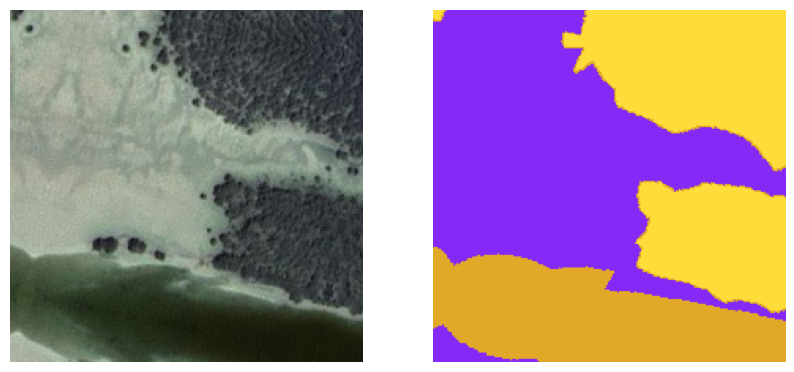

In [16]:

fig,axes=plt.subplots(1,2,figsize=(10,6))
axes[0].imshow(x[1])
axes[1].imshow(decoder(np.expand_dims(y[1],axis=0)))
axes[0].set_axis_off()
axes[1].set_axis_off()

# Model Prediction For New Image

In [17]:
path='/kaggle/input/new-semantic-segmentation-dataset/Data/Img_to_predict/Screenshot from 2024-08-31 16-05-20.png'


In [18]:
image=Image.open(path)
image = image.convert("RGB")

In [19]:
image.size

(1467, 820)

In [20]:
def decoder(predicted_mask):
    argmaxed=np.argmax(predicted_mask,axis=-1)
    argmaxed=np.squeeze(argmaxed,axis=0)
    new_dict_2=dict()
    count=0
    for i, j in new_dict.items():
        new_dict_2[count]=checker_helper(i)
        count+=1
    rgb_image = np.zeros((224, 224, 3), dtype=np.uint8)
    for key, color in new_dict_2.items():
        rgb_image[argmaxed == key] = color
    return rgb_image

In [21]:
def plot_comparision(image,predicted):
    fig,axes=plt.subplots(1,2,figsize=(10,6))
    axes[0].imshow(image)
    axes[1].imshow(decoder(predicted))
    axes[0].set_axis_off()
    axes[1].set_axis_off()


In [22]:
patch_size=224

In [23]:
SIZE_X = (image.size[0]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (image.size[1]//patch_size)*patch_size

In [24]:
image = image.crop((0 ,0, SIZE_X, SIZE_Y)) 
image = np.array(image)

In [25]:
!pip install patchify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [26]:
from patchify import patchify

In [27]:
image.shape

(672, 1344, 3)

In [28]:
print("Now patchifying image")
patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size) 

Now patchifying image


In [29]:
patches_img.shape

(3, 6, 1, 224, 224, 3)

In [30]:
predicted_array = []
patches_img=np.squeeze(patches_img,axis=2)
# Iterate over all patches
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :] / 255.0  # Normalize patch
        predicted = model.predict(np.expand_dims(single_patch_img,axis=0))  # Predict
        predicted_rgb = decoder(predicted)  # Decode the prediction
        predicted_array.append(predicted_rgb)  # Store the decoded RGB prediction


I0000 00:00:1725804731.375066      74 service.cc:145] XLA service 0x7ad07c00cb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725804731.375106      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725804731.375110      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


I0000 00:00:1725804735.968426      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [31]:
predicted_patches = np.array(predicted_array).reshape(patches_img.shape[0], patches_img.shape[1], 224, 224, 3)


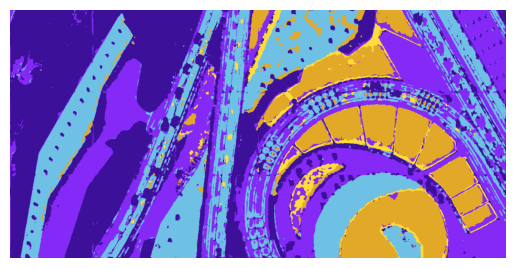

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions
patch_height = 224
patch_width = 224
num_patches_height = patches_img.shape[0]
num_patches_width = patches_img.shape[1]

# Create an empty image of the right size
reconstructed_image = np.zeros((num_patches_height * patch_height, num_patches_width * patch_width, 3), dtype=np.uint8)

# Place patches into the image
for i in range(num_patches_height):
    for j in range(num_patches_width):
        reconstructed_image[i*patch_height:(i+1)*patch_height, j*patch_width:(j+1)*patch_width, :] = predicted_patches[i, j]

# Display the result
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()


In [33]:
reconstructed_image.shape

(672, 1344, 3)

In [34]:
image.shape

(672, 1344, 3)

In [35]:
def plot_comparision(image,predicted):
    fig,axes=plt.subplots(1,2,figsize=(20,20))
    axes[0].imshow(image)
    axes[1].imshow(predicted)
    axes[0].set_axis_off()
    axes[1].set_axis_off()

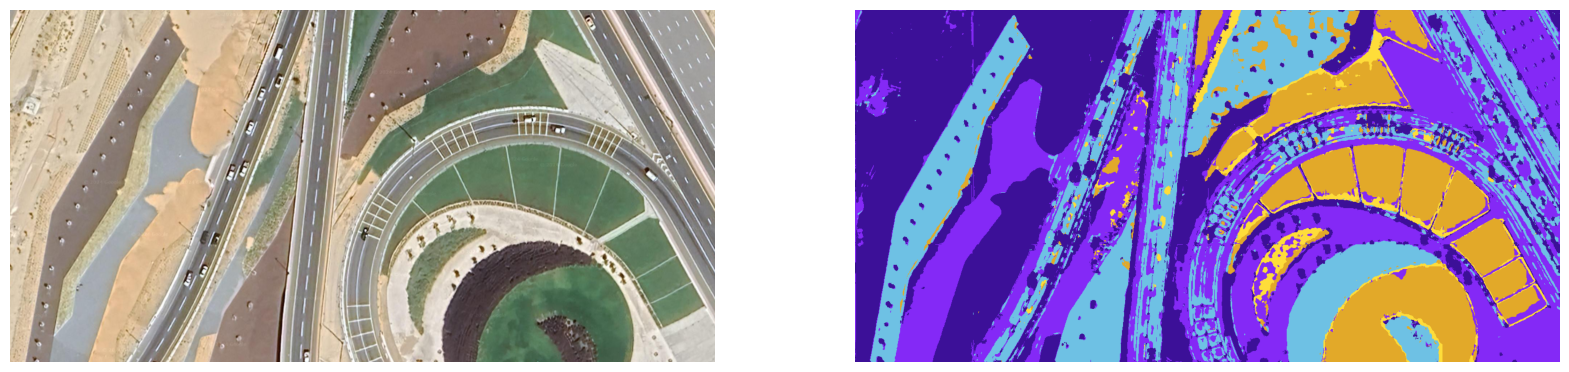

In [36]:
plot_comparision(image,reconstructed_image)